In [63]:
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
tf.get_logger().setLevel(40)  
tf.compat.v1.disable_v2_behavior()  
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D, Reshape
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

import numpy as np
from skimage import io
import os
from alibi.explainers import CEM

In [64]:
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
import torch
import ot
import shap

In [65]:
df = pd.read_excel("all_results_PN.xlsx")
all_results_flat = df.values

## Generating 100 CounterFactual

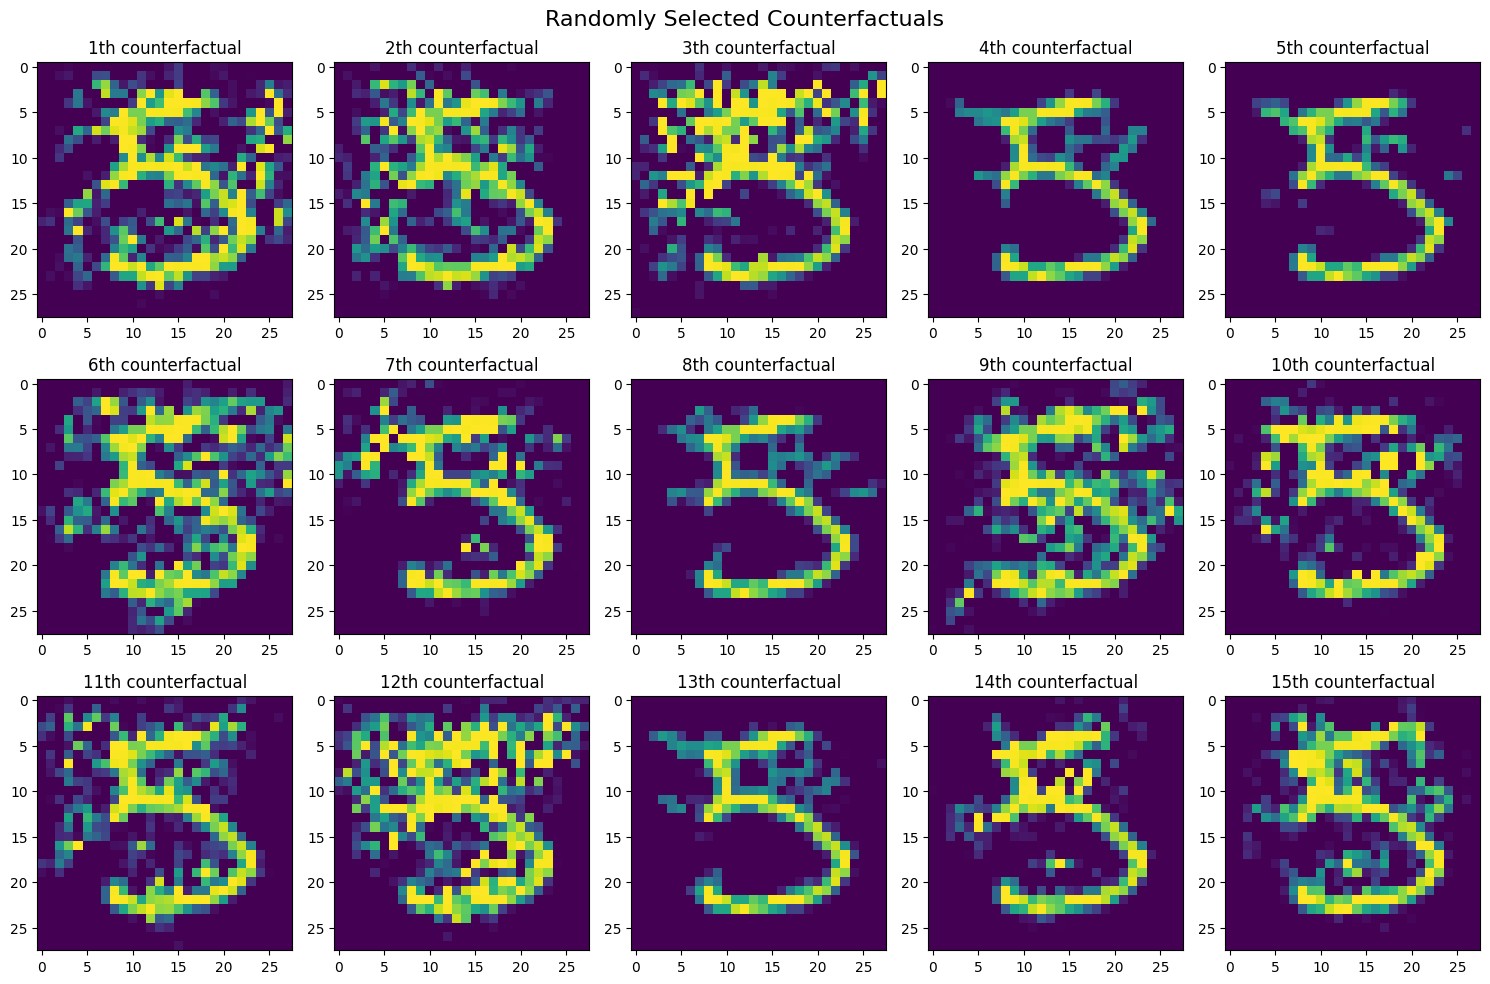

In [66]:
import random
fig, ax = plt.subplots(3, 5, figsize=(15, 10)) 
k=0
random_integers = random.sample(range(0, 100), 15)

for i in range(0,3):
    for j in range(0, 5):
        ax[i,j].imshow(all_results_flat[random_integers[k]].reshape(28,28)) 
        ax[i,j].set_title(f"{k+1}th counterfactual")  
        k += 1
fig.suptitle("Randomly Selected Counterfactuals", fontsize=16)
plt.tight_layout()
plt.show()  


x_train shape: (60000, 28, 28) y_train shape: (60000,)
(10000, 28, 28)
x_train shape: (60000, 784) x_test shape: (10000, 784)
y_train shape: (60000, 10) y_test shape: (10000, 10)


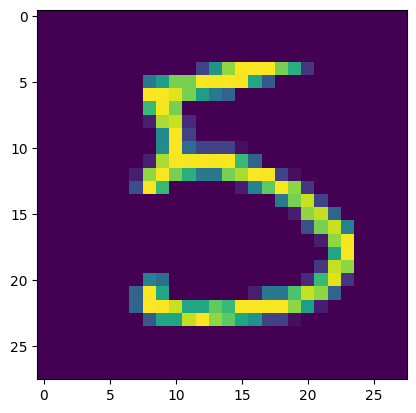

In [67]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)
print(x_test.shape)

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = x_train.reshape(60000,784,)
x_test = x_test.reshape(10000,784,)
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin
x_train_flat = x_train.reshape(-1, 784)  

x_test_flat = x_test.reshape(-1, 784)  

idx = 15
X = x_test_flat[idx].reshape(1, 784)

plt.imshow(X.reshape(28, 28));

In [68]:
Cik = np.zeros((100, 784))
for i, r in enumerate(all_results_flat):
    Cik[i] = (X != r).astype(int)
unchanged_pixels = np.all(Cik == 0, axis=0) 
changed_pixels = np.any(Cik == 1, axis=0) 

# Calculate the number of changed pixels for each image in Cik
num_changed_pixels = np.sum(Cik, axis=1)

# Find the index of the image with the least number of changed pixels
min_changed_index = np.argmin(num_changed_pixels)

# Find the number of changed pixels for this index
min_changed_pixels = num_changed_pixels[min_changed_index]

print(f"The index with the least number of changed pixels is: {min_changed_index}")
print(f"The number of pixels changed in this image is: {min_changed_pixels}")

# 
# X_changed = X[0, changed_pixels] 
# 
# all_results_changed = all_results_flat[:, changed_pixels]  
# 
# print(f"Changed pixels in X: {X_changed.shape}")
# print(f"Changed pixels in all_results: {all_results_changed.shape}")

The index with the least number of changed pixels is: 0
The number of pixels changed in this image is: 101.0


In [69]:
X_tensor = torch.tensor(X, dtype=torch.float32)
all_results_tensor = torch.tensor(all_results_flat, dtype=torch.float32)
print(X_tensor.size(),all_results_tensor.size())

torch.Size([1, 784]) torch.Size([100, 784])


## lOCK THE UNCHANGED PIXEL LOCATION & VALUE
## Reduce the pixel range

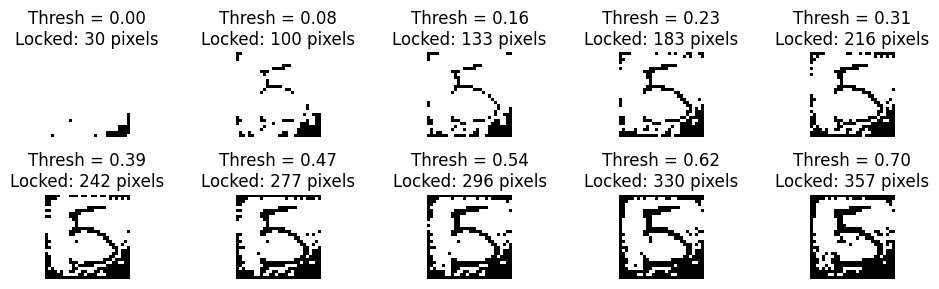

Threshold = 0.00, Locked pixels = 30.0
Threshold = 0.08, Locked pixels = 100.0
Threshold = 0.16, Locked pixels = 133.0
Threshold = 0.23, Locked pixels = 183.0
Threshold = 0.31, Locked pixels = 216.0
Threshold = 0.39, Locked pixels = 242.0
Threshold = 0.47, Locked pixels = 277.0
Threshold = 0.54, Locked pixels = 296.0
Threshold = 0.62, Locked pixels = 330.0
Threshold = 0.70, Locked pixels = 357.0


In [70]:
def lock_pixels_if_static_across_all_images(X, all_results_flat, Thresh):

    weights = np.ones(X.shape, dtype=float)
    static_pixels = np.all([(np.abs(X - all_results_flat[i].reshape(X.shape)) <= Thresh) 
                            for i in range(all_results_flat.shape[0])], axis=0)
    
    weights[static_pixels] = 0 

    return weights

thresholds = np.linspace(0, 0.7, 10)

fig, axes = plt.subplots(2, 5, figsize=(10, 3))

for idx, thresh in enumerate(thresholds):
    weights = lock_pixels_if_static_across_all_images(X, all_results_flat, thresh)
    
    ax = axes[idx//5,idx%5]
    ax.imshow(weights.reshape(28, 28), cmap='gray')
    ax.set_title(f'Thresh = {thresh:.2f}\nLocked: {784-weights.sum():.0f} pixels')
    ax.axis('off')

plt.tight_layout()
plt.show()

for thresh in thresholds:
    weights = lock_pixels_if_static_across_all_images(X, all_results_flat, thresh)
    print(f'Threshold = {thresh:.2f}, Locked pixels = {784-weights.sum()}')


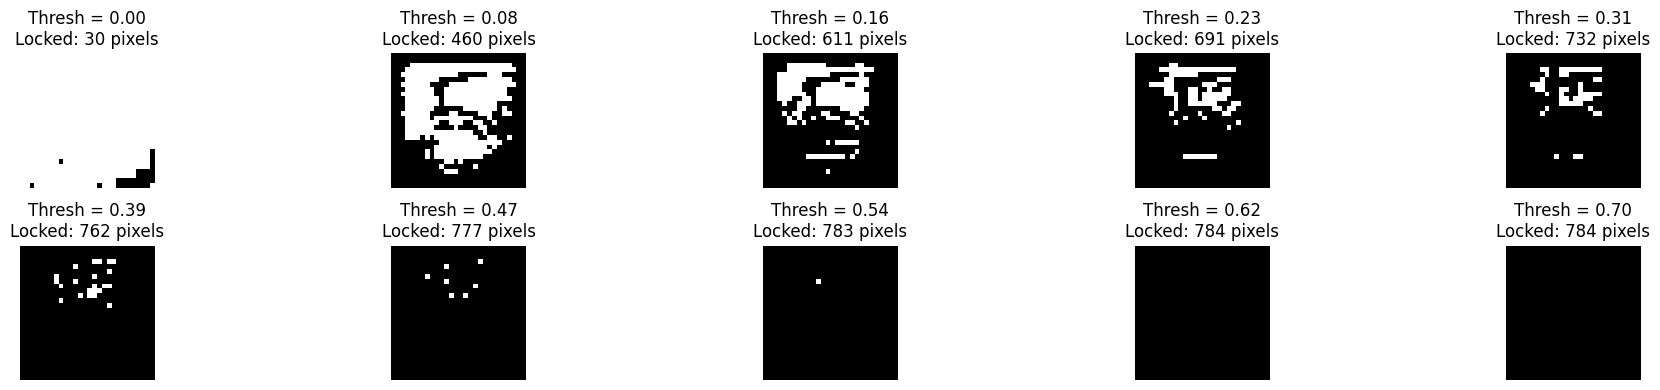

Threshold = 0.00, Locked pixels = 30.0
Threshold = 0.08, Locked pixels = 460.0
Threshold = 0.16, Locked pixels = 611.0
Threshold = 0.23, Locked pixels = 691.0
Threshold = 0.31, Locked pixels = 732.0
Threshold = 0.39, Locked pixels = 762.0
Threshold = 0.47, Locked pixels = 777.0
Threshold = 0.54, Locked pixels = 783.0
Threshold = 0.62, Locked pixels = 784.0
Threshold = 0.70, Locked pixels = 784.0


In [154]:
def normalize_image(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))

def lock_pixels_based_on_aggregation(X, all_results_flat, Thresh):
    concatenated_images = np.concatenate([normalized_X[None, ...], normalized_images], axis=0)

    aggregated_image = np.sum(concatenated_images, axis=0)
    normalized_aggregated_image = aggregated_image / concatenated_images.shape[0]  
    weights = np.ones(X.shape, dtype=float)  
    diff = np.abs(normalized_aggregated_image - normalized_X)  
    weights[diff <= Thresh] = 0 

    return weights

thresholds = np.linspace(0, 0.7, 10)

fig, axes = plt.subplots(2, 5, figsize=(20, 4))

normalized_X = normalize_image(X)
normalized_images = np.array([normalize_image(all_results_flat[i].reshape(X.shape)) for i in range(all_results_flat.shape[0])])

for i, thresh in enumerate(thresholds):
    weights = lock_pixels_based_on_aggregation(X, all_results_flat, thresh)
    
    ax = axes[i//5,i%5]
    ax.imshow(weights.reshape(28, 28), cmap='gray')
    ax.set_title(f'Thresh = {thresh:.2f}\nLocked: {784-weights.sum():.0f} pixels')
    ax.axis('off')

plt.tight_layout()
plt.show()

for thresh in thresholds:
    weights = lock_pixels_based_on_aggregation(X, all_results_flat, thresh)
    print(f'Threshold = {thresh:.2f}, Locked pixels = {784-weights.sum()}')


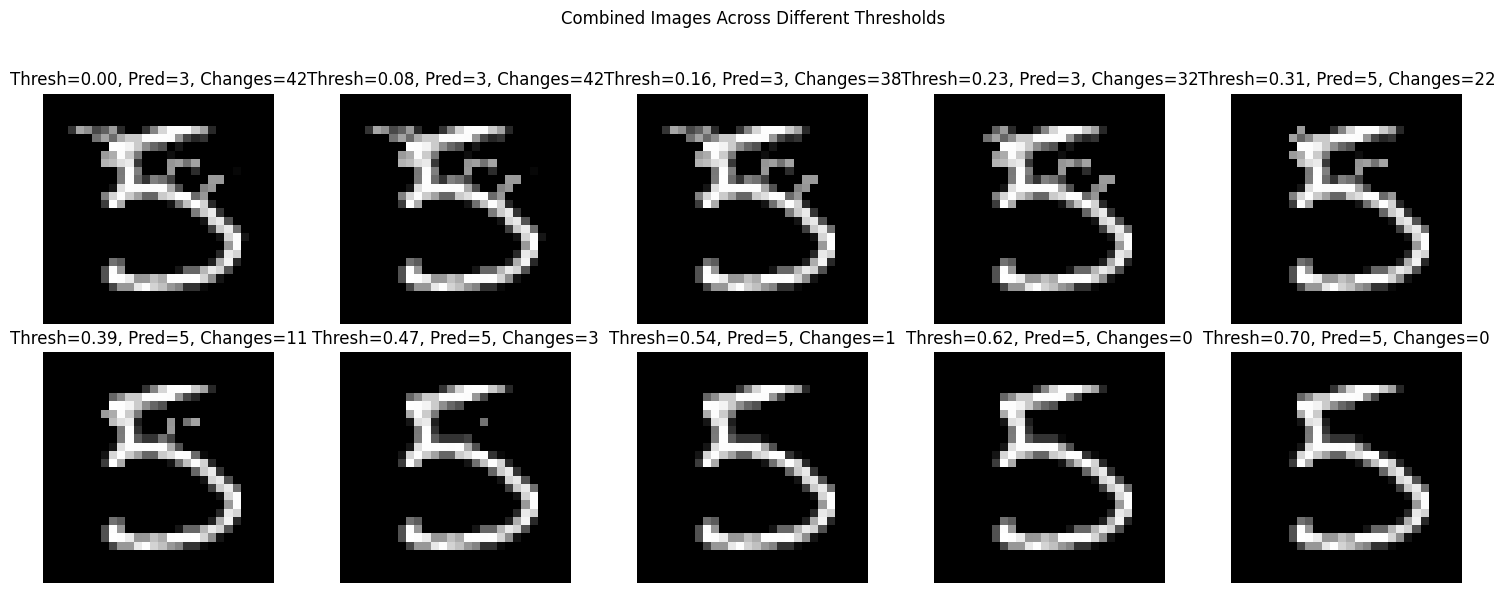

In [142]:
cnn = load_model('mnist_cnn.h5')

# Combine unblocked pixels from X_tensor and blocked pixels from all_results_flat[i] into one image
def combine_pixels(X_tensor, all_results_flat, weights):
    combined_images = []
    for i in range(all_results_flat.shape[0]):  # Iterate through each image in all_results_flat
        combined_image = np.copy(X_tensor)  # Start with X_tensor
        blocked_indices = weights == 0  # No need to flatten weights, keep 2D structure
        unblocked_indices = weights > 0  # No need to flatten weights, keep 2D structure

        # Apply blocked pixels from all_results_flat[i] to the combined image
        combined_image[blocked_indices] = X_tensor[blocked_indices]
        combined_image[unblocked_indices] = all_results_flat[i][unblocked_indices.flatten()]
        
        combined_images.append(combined_image)  # Append to the list of combined images
    return np.array(combined_images)

# Define number of rows and columns based on the number of thresholds
num_columns = 5
num_rows = (len(thresholds) + num_columns - 1) // num_columns

# Create a subplot grid for all thresholds
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 3 * num_rows))
fig.suptitle("Combined Images Across Different Thresholds")

# Iterate over each threshold and plot its result in the subplot grid
for i, thresh in enumerate(thresholds):
    weights = lock_pixels_based_on_aggregation(X, all_results_flat, thresh)
    combined_images = combine_pixels(X_tensor, all_results_flat, weights)
    
    # Predict using CNN and get the first image's prediction
    pred = cnn.predict(combined_images[0].reshape(1, 784)).argmax()

    # Calculate the number of changed pixels between the original image X and the combined image
    changed_pixels = np.sum(X != combined_images[0])  # Count non-matching pixels

    # Place the image in the corresponding subplot
    row, col = divmod(i, num_columns)
    ax = axes[row, col] if num_rows > 1 else axes[col]
    ax.imshow(combined_images[0].reshape(28, 28), cmap='gray')  # Display the first image for this threshold
    ax.set_title(f'Thresh={thresh:.2f}, Pred={pred}, Changes={changed_pixels}')
    ax.axis('off')  # Hide axes ticks

# Hide unused subplots
for j in range(i + 1, num_rows * num_columns):
    row, col = divmod(j, num_columns)
    ax = axes[row, col] if num_rows > 1 else axes[col]
    ax.axis('off')
    
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
plt.show()


## Finding the most diverse counterfactuals

Most diverse images are at indices: [64 76 99 81 48 98 91 86 89 77]


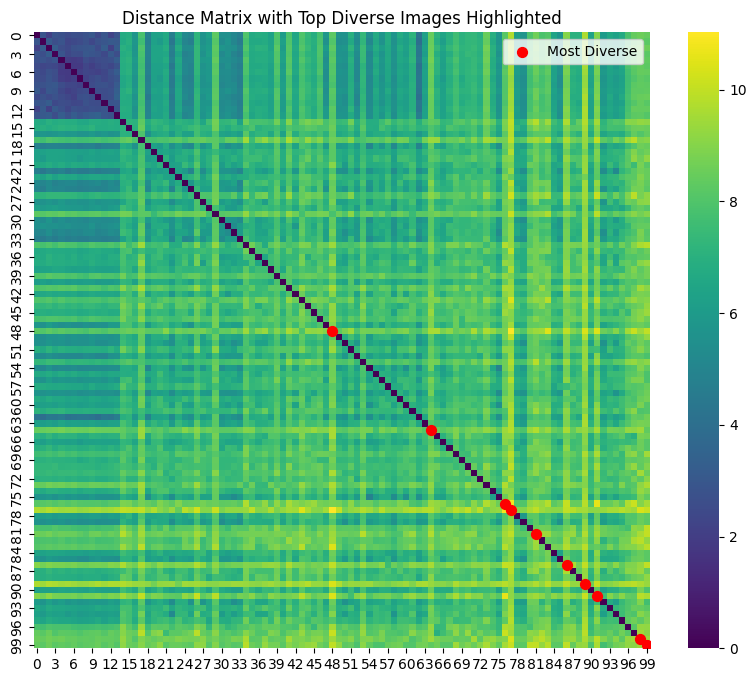

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

def calculate_distance_matrix(all_results_flat):

    flattened_images = np.array([img.flatten() for img in all_results_flat])
    
    distance_matrix = squareform(pdist(flattened_images, metric='euclidean'))
    
    return distance_matrix

def find_most_diverse_images(distance_matrix, top_n=10):

    avg_distances = np.mean(distance_matrix, axis=1)

    most_diverse_indices = np.argsort(avg_distances)[-top_n:]  
    
    return most_diverse_indices

def visualize_distance_matrix_with_highlights(distance_matrix, highlighted_indices):

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(distance_matrix, cmap='viridis', square=True)
    plt.title("Distance Matrix with Top Diverse Images Highlighted")
    
    for idx in highlighted_indices:
        plt.scatter(idx + 0.5, idx + 0.5, color='red', s=50, label='Most Diverse' if idx == highlighted_indices[0] else "")
    
    plt.legend(loc="upper right")
    plt.show()

distance_matrix = calculate_distance_matrix(all_results_flat)

most_diverse_images = find_most_diverse_images(distance_matrix, top_n=10)
print("Most diverse images are at indices:", most_diverse_images)

visualize_distance_matrix_with_highlights(distance_matrix, most_diverse_images)


Most diverse images are at indices: [96 41 83 39 99 29 97 98 73 64 81 86 91 77 89]


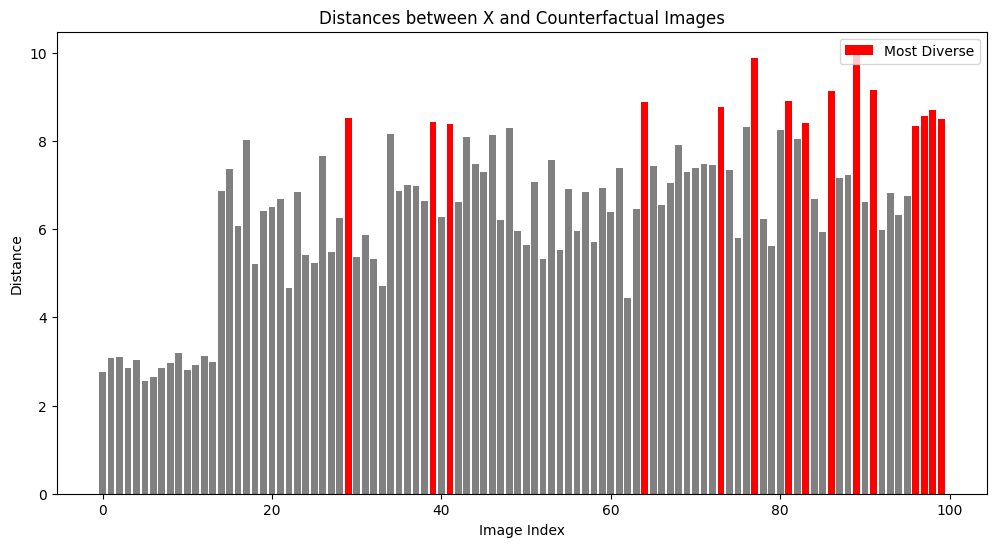

In [156]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean

def calculate_distances(X, all_results_flat):
    X_flattened = X.flatten()

    distances = np.array([euclidean(X_flattened, img.flatten()) for img in all_results_flat])
    
    return distances

def find_most_diverse_images(distances, top_n=15):
    most_diverse_indices = np.argsort(distances)[-top_n:]  
    
    return most_diverse_indices

def visualize_distances_with_highlights(distances, highlighted_indices):
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(distances)), distances, color='gray')
    plt.title("Distances between X and Counterfactual Images")

    # Highlight the most diverse images in red
    for idx in highlighted_indices:
        plt.bar(idx, distances[idx], color='red', label='Most Diverse' if idx == highlighted_indices[0] else "")
    
    plt.xlabel('Image Index')
    plt.ylabel('Distance')
    plt.legend(loc="upper right")
    plt.show()

X_flat = X_tensor.cpu().numpy().flatten()  # Flatten the original image

distances = calculate_distances(X_flat, all_results_flat)

largest_distance_images = find_most_diverse_images(distances, top_n=15)
print("Most diverse images are at indices:", largest_distance_images)

visualize_distances_with_highlights(distances, largest_distance_images)


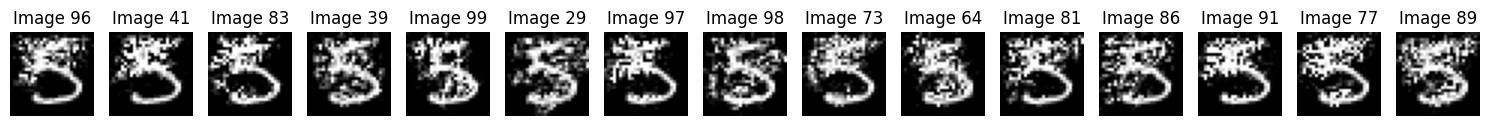

In [157]:
fig, axes = plt.subplots(1, len(largest_distance_images), figsize=(15, 5))
for i, idx in enumerate(largest_distance_images):
    ax = axes[i]
    ax.imshow(all_results_flat[idx].reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Image {idx}")

plt.tight_layout()
plt.show()

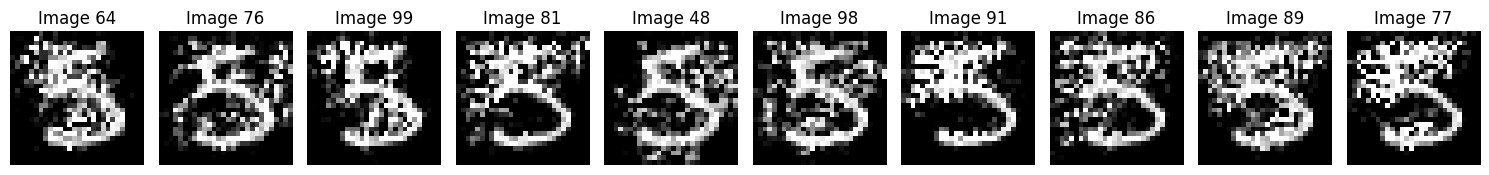

In [75]:
fig, axes = plt.subplots(1, len(most_diverse_images), figsize=(15, 5))
for i, idx in enumerate([64,76,99, 81, 48, 98, 91, 86, 89, 77]):
    ax = axes[i]
    ax.imshow(all_results_flat[idx].reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Image {idx}")

plt.tight_layout()
plt.show()

In [76]:
# from sklearn.cluster import KMeans

# def cluster_images(distance_matrix, n_clusters=10):

#     kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#     labels = kmeans.fit_predict(distance_matrix)

#     cluster_centers = kmeans.cluster_centers_

#     representative_images = []
#     for i in range(n_clusters):
#         cluster_idx = np.where(labels == i)[0]
#         center_idx = np.argmin(np.linalg.norm(distance_matrix[cluster_idx] - cluster_centers[i], axis=1))
#         representative_images.append(cluster_idx[center_idx])
    
#     return representative_images

# representative_images = cluster_images(distance_matrix, n_clusters=10)

# print("Representative images are at indices:", representative_images)


In [77]:
# fig, axes = plt.subplots(1, len(representative_images), figsize=(15, 5))
# for i, idx in enumerate(representative_images):
#     ax = axes[i]
#     ax.imshow(all_results_flat[idx].reshape(28, 28), cmap='gray')
#     ax.axis('off')
#     ax.set_title(f"Image {idx}")

# plt.tight_layout()
# plt.show()

In [158]:
def find_changed_pixels(X, image):
    return np.where(X != image) 

def calculate_pixel_changes(X, selected_images, all_results_flat):

    all_changed_pixels = set()
    for R in all_results_flat:
        changed_pixels = find_changed_pixels(X, R.reshape(X.shape))
        all_changed_pixels.update(zip(*changed_pixels))  
    c_ik_total = len(all_changed_pixels)

    selected_changed_pixels = set()
    for idx in selected_images:
        changed_pixels = find_changed_pixels(X, all_results_flat[idx].reshape(X.shape))
        selected_changed_pixels.update(zip(*changed_pixels))
    c_ik_diverse = len(selected_changed_pixels)

    proportion = c_ik_diverse / c_ik_total if c_ik_total > 0 else 0
    return c_ik_diverse, c_ik_total, proportion

c_ik_kmeans, c_ik_total, proportion_kmeans = calculate_pixel_changes(X, largest_distance_images, all_results_flat)
print(f"largest distance selected images - Changed pixels: {c_ik_kmeans}, Total pixels changed in 100 R: {c_ik_total}, Proportion: {proportion_kmeans:.2f}")

c_ik_diverse, c_ik_total, proportion_diverse = calculate_pixel_changes(X, most_diverse_images, all_results_flat)
print(f"Most diverse images - Changed pixels: {c_ik_diverse}, Total pixels changed in 100 R: {c_ik_total}, Proportion: {proportion_diverse:.2f}")

# combined_images = np.concatenate([representative_images, most_diverse_images])
# c_ik_combined, _, proportion_combined = calculate_pixel_changes(X, combined_images, all_results_flat)
# print(f"Combined selected images - Changed pixels: {c_ik_combined}, Total pixels changed in 100 R: {c_ik_total}, Proportion: {proportion_combined:.2f}")

largest distance selected images - Changed pixels: 680, Total pixels changed in 100 R: 754, Proportion: 0.90
Most diverse images - Changed pixels: 697, Total pixels changed in 100 R: 754, Proportion: 0.92


## Finding the one image with largest joint-probability 

In [79]:
# import torch
# import ot
# import numpy as np

# # Class to compute Wasserstein Divergence
# class WassersteinDivergence:
#     def __init__(self, reg=1e-5):
#         self.nu = None
#         self.reg = reg

#     def distance(self, y_s: torch.tensor, y_t: torch.tensor, delta):
#         # Validate delta
#         if delta < 0 or delta > 0.5:
#             raise ValueError("Delta should be between 0 and 0.5")

#         y_s = y_s.squeeze()
#         y_t = y_t.squeeze()

#         # Calculate quantiles
#         lower_quantile_s = torch.quantile(y_s, delta)
#         upper_quantile_s = torch.quantile(y_s, 1 - delta)
#         lower_quantile_t = torch.quantile(y_t, delta)
#         upper_quantile_t = torch.quantile(y_t, 1 - delta)

#         # Indices in the original tensors that correspond to the filtered values
#         indices_s = torch.where((y_s >= lower_quantile_s) & (y_s <= upper_quantile_s))[0]
#         indices_t = torch.where((y_t >= lower_quantile_t) & (y_t <= upper_quantile_t))[0]

#         # Create a meshgrid to identify the locations in self.nu to be updated
#         indices_s_grid, indices_t_grid = torch.meshgrid(indices_s, indices_t, indexing="ij")

#         # Filter data points
#         y_s_filtered = y_s[indices_s]
#         y_t_filtered = y_t[indices_t]

#         proj_y_s_dist_mass = torch.ones(len(y_s_filtered)) / len(y_s_filtered)
#         proj_y_t_dist_mass = torch.ones(len(y_t_filtered)) / len(y_t_filtered)

#         # Compute pairwise cost matrix (sqeuclidean distance)
#         trimmed_M_y = ot.dist(
#             y_s_filtered.reshape(y_s_filtered.shape[0], 1),
#             y_t_filtered.reshape(y_t_filtered.shape[0], 1),
#             metric="sqeuclidean",
#         ).to("cpu")

#         # Compute the optimal transport plan
#         trimmed_nu = ot.emd(proj_y_s_dist_mass, proj_y_t_dist_mass, trimmed_M_y)

#         # Wasserstein distance
#         dist = torch.sum(trimmed_nu * trimmed_M_y) * (1 / (1 - 2 * delta))

#         # Store the transport plan (joint distribution)
#         self.nu = torch.zeros(len(y_s), len(y_t))
#         self.nu[indices_s_grid, indices_t_grid] = trimmed_nu

#         return dist, self.nu

# most_diverse_tensor = torch.tensor([all_results_flat[i].reshape(-1) for i in most_diverse_images], dtype=torch.float32)  # Shape (100, 784)

# # Initialize WassersteinDivergence model
# ot_model = WassersteinDivergence(reg=1e-5)
# delta = 0.01  # Set delta value (quantile threshold)

# # Compute Wasserstein distances and joint probabilities for most_diverse_images
# distances = []
# joint_probabilities_list = [] 

# for i in range(most_diverse_tensor.shape[0]):
#     dist, nu = ot_model.distance(X_tensor, most_diverse_tensor[i], delta)
#     distances.append(dist.item())  # Store the distance as a scalar
#     joint_probabilities_list.append(nu)  # Store the joint distribution

# def softmax(distances, temperature=0.1):
#     exp_distances = np.exp(-np.array(distances) / temperature) 
#     return exp_distances / np.sum(exp_distances)


# p_values = softmax(distances)  

# print(f"Joint probabilities (1, 10): {p_values}")


In [80]:
import torch
import numpy as np
import ot
import matplotlib.pyplot as plt

class WassersteinDivergence:
    def __init__(self, reg=1):
        self.nu = None
        self.reg = reg

    def distance(self, y_s: torch.tensor, y_t: torch.tensor, weights: torch.tensor, delta):
        if delta < 0 or delta > 0.5:
            raise ValueError("Delta should be between 0 and 0.5")

        y_s = y_s.squeeze()
        y_t = y_t.squeeze()

        y_s_filtered = y_s[weights > 0]
        y_t_filtered = y_t[weights > 0]

        proj_y_s_dist_mass = torch.ones(len(y_s_filtered)) / len(y_s_filtered)
        proj_y_t_dist_mass = torch.ones(len(y_t_filtered)) / len(y_t_filtered)

        trimmed_M_y = ot.dist(
            y_s_filtered.reshape(y_s_filtered.shape[0], 1),
            y_t_filtered.reshape(y_t_filtered.shape[0], 1),
            metric="sqeuclidean",
        ).to("cpu")

        trimmed_nu = ot.emd(proj_y_s_dist_mass, proj_y_t_dist_mass, trimmed_M_y)

        dist = torch.sum(trimmed_nu * trimmed_M_y) * (1 / (1 - 2 * delta))

        return dist

def lock_pixels_if_static_across_all_images(X, most_diverse_images, Thresh=0):
    weights = np.ones(X.shape, dtype=float)
    static_pixels = np.all([(np.abs(X - img.reshape(X.shape)) <= Thresh) 
                            for img in most_diverse_images], axis=0)
    weights[static_pixels] = 0  
    return weights

def compute_joint_distribution_with_weights(X, most_diverse_images, delta=0.1, Thresh=0, reg=1):
    ot_model = WassersteinDivergence(reg=reg)
    X_tensor = torch.tensor(X, dtype=torch.float32)
    
    weights = lock_pixels_if_static_across_all_images(X, most_diverse_images, Thresh)
    weights_tensor = torch.tensor(weights, dtype=torch.float32)

    distances = []

    for R_image in most_diverse_images:
        R_tensor = torch.tensor(R_image, dtype=torch.float32)
        dist = ot_model.distance(X_tensor, R_tensor, weights_tensor, delta)
        distances.append(dist.item())  

    return distances

def softmax(distances, temperature=0.05):
    exp_distances = np.exp(-np.array(distances) / temperature)  
    return exp_distances / np.sum(exp_distances)

X = x_test[idx].reshape(784)  
most_diverse_images_ = [all_results_flat[i].reshape(784) for i in most_diverse_images]  # 展平反事实图像

distances = compute_joint_distribution_with_weights(X, most_diverse_images_, delta=0.1, Thresh=0)

joint_probabilities = softmax(distances, temperature=0.05)

print(f"Joint probabilities with weights: {joint_probabilities}")


Joint probabilities with weights: [0.11072735 0.13924953 0.13316047 0.11461353 0.12496275 0.09971927
 0.0825316  0.09242503 0.05119601 0.05141447]


In [81]:
most_diverse_tensor = torch.tensor(most_diverse_images_)

C:\Users\dilar\AppData\Local\Temp\ipykernel_25748\2192046635.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  most_diverse_tensor = torch.tensor(most_diverse_images_)


In [82]:
from sklearn.metrics.pairwise import cosine_similarity

X_flat = X_tensor.flatten().numpy()
cosine_similarities = []

for i in range(most_diverse_tensor.shape[0]):
    R_flat = most_diverse_tensor[i].flatten().numpy()
    sim = cosine_similarity(X_flat.reshape(1, -1), R_flat.reshape(1, -1))[0][0]
    cosine_similarities.append(sim)

cosine_p_values = softmax(cosine_similarities, temperature=0.1)

print(f"Cosine similarity-based probabilities: {cosine_p_values}")


Cosine similarity-based probabilities: [0.08860203 0.06798861 0.07036876 0.09012077 0.06835167 0.08589758
 0.09561048 0.10542698 0.17998559 0.14764753]


In [83]:
most_diverse_images_ = np.array(most_diverse_images_)

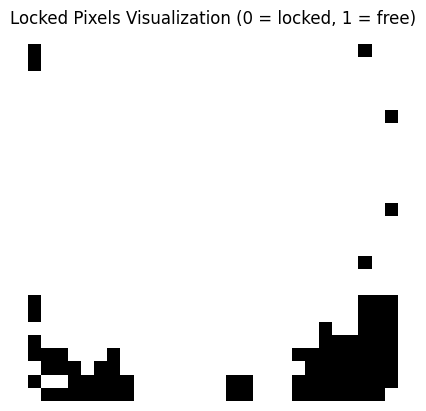

Number of locked pixels: 81


In [84]:
locked_weights = lock_pixels_if_static_across_all_images(X, most_diverse_images_, Thresh=0)
plt.imshow(locked_weights.reshape(28, 28), cmap='gray')
plt.title(f"Locked Pixels Visualization (0 = locked, 1 = free)")
plt.axis('off')
plt.show()

# Print the number of locked pixels
num_locked_pixels = np.sum(locked_weights == 0)
print(f"Number of locked pixels: {num_locked_pixels}")

In [85]:
print(joint_probabilities.shape)

(10,)


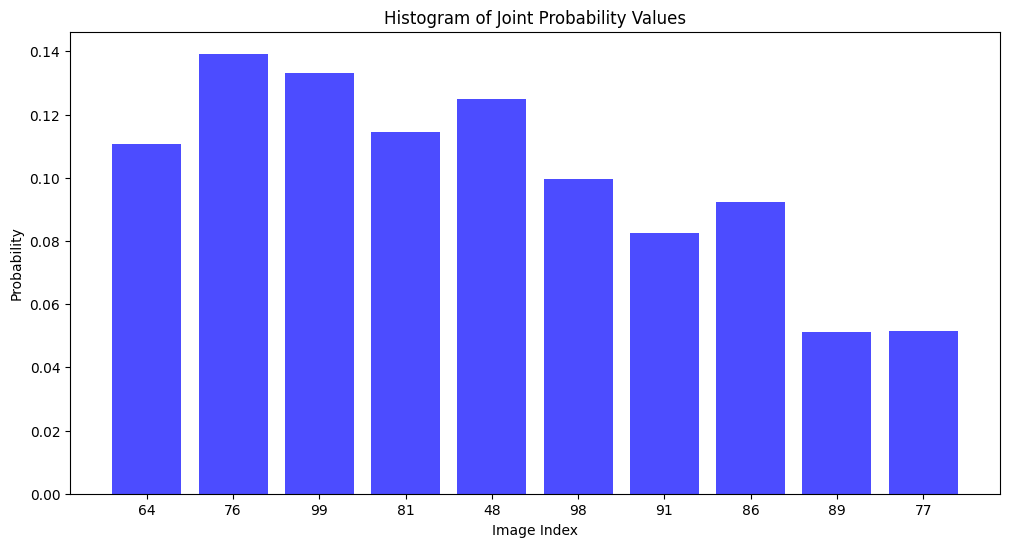

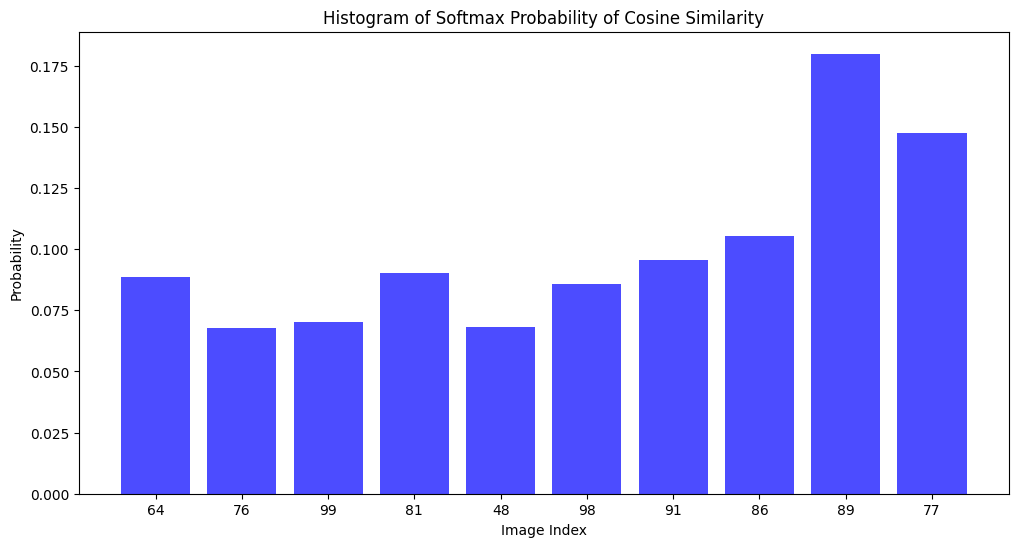

In [86]:
num_images = len(most_diverse_images)
image_indices = np.arange(1, num_images + 1) 

plt.figure(figsize=(12, 6))
plt.bar(image_indices, joint_probabilities, color='blue', alpha=0.7)
plt.xlabel('Image Index')
plt.ylabel('Probability')
plt.title('Histogram of Joint Probability Values')
plt.xticks(image_indices, most_diverse_images)  
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(image_indices, cosine_p_values, color='blue', alpha=0.7)
plt.xlabel('Image Index')
plt.ylabel('Probability')
plt.title('Histogram of Softmax Probability of Cosine Similarity')
plt.xticks(image_indices, most_diverse_images) 
plt.show()


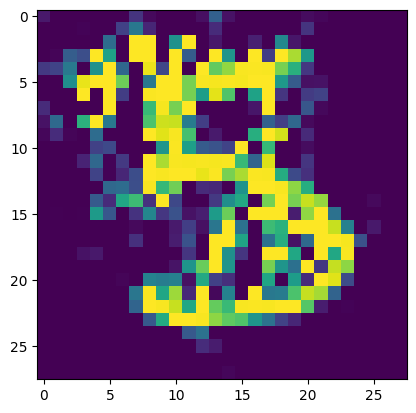

In [87]:
most_diverse_images_ = [all_results_flat[most_diverse_images[i]].reshape(28,28) for i in range(0,len(most_diverse_images))]
plt.imshow(most_diverse_images_[2])
plt.show()

In [88]:
# X = X_flat.reshape(28, 28)

# joint_max_indices = [99, 76, 81] 
# cosine_max_index = 89  

# def plot_images(X, most_diverse_images_, joint_max_indices, cosine_max_index, most_diverse_images):
#     fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    
#     # Plot original image X
#     axes[0].imshow(X.reshape(28, 28), cmap='gray')
#     axes[0].set_title("Original X")
#     axes[0].axis('off')
    
#     for i, idx in enumerate(joint_max_indices):
#         img_idx = np.where(most_diverse_images == idx)[0][0]  # Find the index position in the array
#         print(img_idx)
#         axes[i+1].imshow(most_diverse_images_[img_idx].reshape(28, 28), cmap='gray')
#         axes[i+1].set_title(f"Joint Max {idx}")
#         axes[i+1].axis('off')
    
#     cosine_img_idx = np.where(most_diverse_images == cosine_max_index)[0][0]
#     axes[4].imshow(most_diverse_images_[cosine_img_idx].reshape(28, 28), cmap='gray')
#     axes[4].set_title(f"Cosine Max {cosine_max_index}")
#     axes[4].axis('off')
    
#     plt.tight_layout()
#     plt.show()

# plot_images(X, most_diverse_images_, joint_max_indices, cosine_max_index, most_diverse_images)


1.0


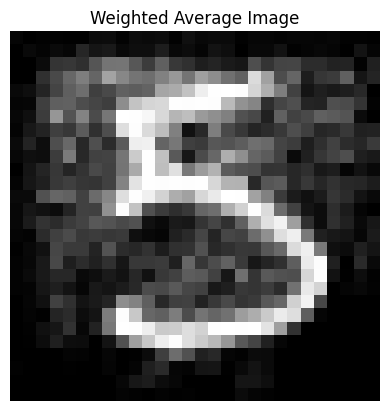

In [89]:
def create_weighted_image(most_diverse_images_, joint_probabilities):

    joint_probabilities = joint_probabilities / np.sum(joint_probabilities)
    print(joint_probabilities.sum())  
    weighted_image = np.zeros((28, 28))  

    for i in range(len(most_diverse_images_)):
        weighted_image += most_diverse_images_[i] * joint_probabilities[i]
    
    return weighted_image

most_diverse_images_reshaped = np.array([img.reshape(28, 28) for img in most_diverse_images_])

weighted_image = create_weighted_image(most_diverse_images_reshaped, joint_probabilities)

plt.imshow(weighted_image, cmap='gray')
plt.title('Weighted Average Image')
plt.axis('off')
plt.show()


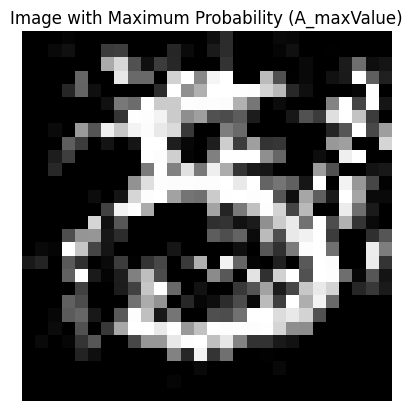

In [90]:
def create_max_image(most_diverse_images_, joint_probabilities):

    most_diverse_images_ = np.array(most_diverse_images_)

    max_prob_index = np.argmax(joint_probabilities)

    max_image = most_diverse_images_[max_prob_index]
    
    return max_image

most_diverse_images_reshaped = np.array([img.reshape(28, 28) for img in most_diverse_images_])

max_image = create_max_image(most_diverse_images_reshaped, joint_probabilities)

plt.imshow(max_image, cmap='gray')
plt.title('Image with Maximum Probability (A_maxValue)')
plt.axis('off')
plt.show()


1


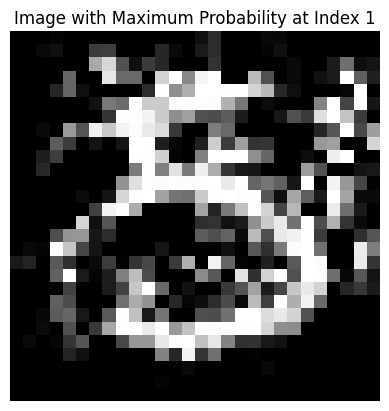

In [91]:
max_p_index = np.argmax(joint_probabilities)
print(max_p_index)
best_image = most_diverse_images_[max_p_index].reshape(28, 28)

plt.imshow(best_image, cmap='gray')
plt.title(f'Image with Maximum Probability at Index {max_p_index}')
plt.axis('off')
plt.show()


In [92]:
# class WassersteinDivergence:
#     def __init__(self, reg=1):
#         self.nu = None
#         self.reg = reg

#     def distance(self, y_s: torch.tensor, y_t: torch.tensor, delta):
#         # Validate delta
#         if delta < 0 or delta > 0.5:
#             raise ValueError("Delta should be between 0 and 0.5")

#         y_s = y_s.squeeze()
#         y_t = y_t.squeeze()

#         # Calculate quantiles
#         lower_quantile_s = torch.quantile(y_s, delta)
#         upper_quantile_s = torch.quantile(y_s, 1 - delta)
#         lower_quantile_t = torch.quantile(y_t, delta)
#         upper_quantile_t = torch.quantile(y_t, 1 - delta)

#         # Indices in the original tensors that correspond to the filtered values
#         indices_s = torch.where((y_s >= lower_quantile_s) & (y_s <= upper_quantile_s))[0]
#         indices_t = torch.where((y_t >= lower_quantile_t) & (y_t <= upper_quantile_t))[0]

#         # Create a meshgrid to identify the locations in self.nu to be updated
#         indices_s_grid, indices_t_grid = torch.meshgrid(indices_s, indices_t, indexing="ij")

#         # Filter data points
#         y_s_filtered = y_s[indices_s]
#         y_t_filtered = y_t[indices_t]

#         proj_y_s_dist_mass = torch.ones(len(y_s_filtered)) / len(y_s_filtered)
#         proj_y_t_dist_mass = torch.ones(len(y_t_filtered)) / len(y_t_filtered)

#         trimmed_M_y = ot.dist(
#             y_s_filtered.reshape(y_s_filtered.shape[0], 1),
#             y_t_filtered.reshape(y_t_filtered.shape[0], 1),
#             metric="sqeuclidean",
#         ).to("cpu")

#         trimmed_nu = ot.emd(proj_y_s_dist_mass, proj_y_t_dist_mass, trimmed_M_y)

#         dist = torch.sum(trimmed_nu * trimmed_M_y) * (1 / (1 - 2 * delta))

#         self.nu = torch.zeros(len(y_s), len(y_t))
#         self.nu[indices_s_grid, indices_t_grid] = trimmed_nu

#         return dist, self.nu

# X_tensor = torch.tensor(X, dtype=torch.float32)
# all_results_tensor = torch.tensor(all_results_flat, dtype=torch.float32)

# ot_model = WassersteinDivergence(reg=1)
# delta = 0.1  
# distances = []
# joint_probabilities_list = [] 

# for i in range(all_results_tensor.shape[0]):
#     dist, nu = ot_model.distance(X_tensor, all_results_tensor[i], delta)
#     distances.append(dist)
#     joint_probabilities_list.append(nu)  

# ot_distances = distances

# def softmax(distances):
#     exp_distances = np.exp(-np.array(distances)) 
#     return exp_distances / np.sum(exp_distances) 

# p_values = softmax(ot_distances)  

# max_p_index = np.argmax(p_values)  
# max_p = p_values[max_p_index]
# # best_r = all_results_tensor[max_p_index] 

# print(f"max p: {max_p}")
# print(f"maxp index: {max_p_index}")

# # min_distance = min(distances)
# # min_index = distances.index(min_distance)
# # 
# # min_distance, min_index

# joint_probabilities = joint_probabilities_list[max_p_index]  
# # 
# # print("Joint probabilities for sample with min OT distance:", joint_probabilities)

In [93]:
# c_ik = np.where(X.reshape(28,28) != all_results_flat[max_p_index].reshape(28,28), 1, 0)
# print(np.sum(c_ik))

In [94]:
best_image = max_image

## Using pixel-by-pixel replacing to reduce the needed changes; Result=23

447


d:\Anaconda\envs\course02502\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


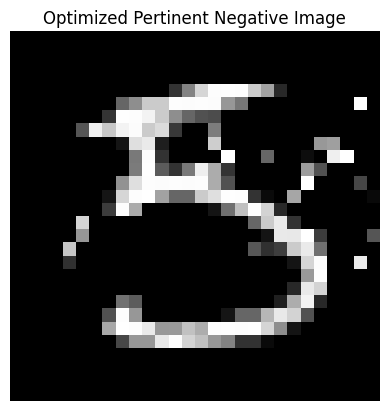

In [95]:
cnn = load_model('mnist_cnn.h5')
c_ik = np.where(X.reshape(28,28) != best_image.reshape(28,28), 1, 0)
print(np.sum(c_ik))
PN_optimized1 = best_image.copy()
c_ik_cp = c_ik.copy()  
X_reshaped = X_tensor.cpu().numpy().reshape(28, 28)  

for i in range(28):
    for j in range(28):
        if c_ik_cp[i, j] == 1:
            PN_temp = PN_optimized1.copy()
            PN_temp[i, j] = X_reshaped[i, j] 
            prediction_temp = cnn.predict(PN_temp.reshape(1, 784))
            if prediction_temp.argmax() == 3:
                PN_optimized1[i, j] = X_reshaped[i, j]  

plt.imshow(PN_optimized1.reshape(28, 28), cmap='gray')
plt.title('Optimized Pertinent Negative Image')
plt.axis('off')
plt.show()


252


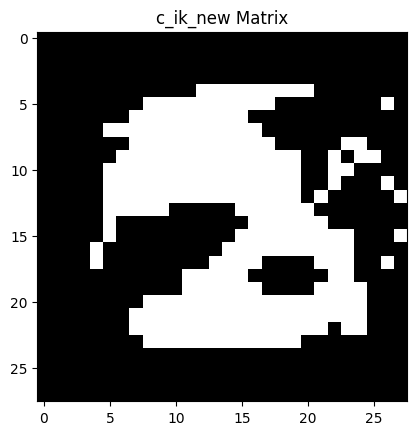

3


In [96]:
c_ik_cp = np.where(X.reshape(28,28) != PN_optimized1.reshape(28,28), 1, 0)
changed_pixel_opti = np.sum(c_ik_cp)
print(changed_pixel_opti)
plt.imshow(c_ik_cp.reshape(28,28),cmap='gray')
plt.title('c_ik_new Matrix')
plt.show()
print(cnn.predict(PN_optimized1.reshape(1,784)).argmax())

## Calculating the shap_values based on the counterfacutal R

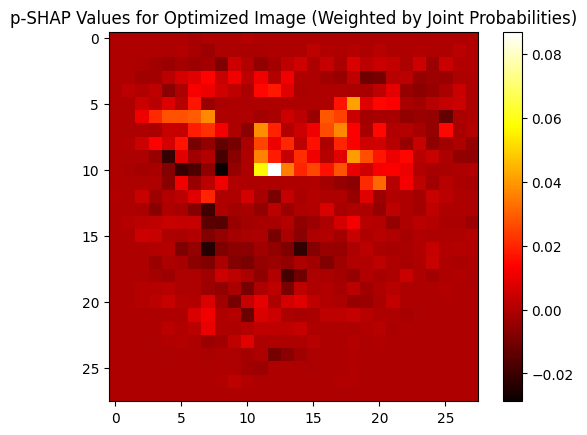

In [97]:
def calculate_p_shap(X, most_diverse_images_, cnn, target_label, joint_probabilities):
    X_reshaped = X.reshape(28, 28)  

    most_diverse_images_ = np.array(most_diverse_images_)
    
    num_counterfactuals = most_diverse_images_.shape[0] 
    joint_probabilities = joint_probabilities / np.sum(joint_probabilities) 

    shap_values = np.zeros((28, 28))  

    for k in range(num_counterfactuals):
        most_diverse_images_reshaped = most_diverse_images_[k].reshape(28, 28) 

        for i in range(28):
            for j in range(28):
                perturbed_image_without = most_diverse_images_reshaped.copy()
                perturbed_image_without[i, j] = X_reshaped[i, j]

                prob_with = cnn.predict(most_diverse_images_reshaped.reshape(1, 784))[0][target_label]
                prob_without = cnn.predict(perturbed_image_without.reshape(1, 784))[0][target_label]

                marginal_contribution = (prob_with - prob_without) * joint_probabilities[k]

                shap_values[i, j] += marginal_contribution

    shap_sum = np.sum(shap_values)
    if shap_sum == 0:
        print("Warning: Sum of SHAP values is zero, applying epsilon for stability.")
        epsilon = 1e-10
        shap_sum = epsilon

    shap_values /= shap_sum  

    return shap_values

X = X_tensor.cpu().numpy()  
p_shap_values = calculate_p_shap(X, most_diverse_images_, cnn, target_label=3, joint_probabilities=joint_probabilities)

plt.imshow(p_shap_values, cmap='hot')
plt.colorbar()
plt.title('p-SHAP Values for Optimized Image (Weighted by Joint Probabilities)')
plt.show()


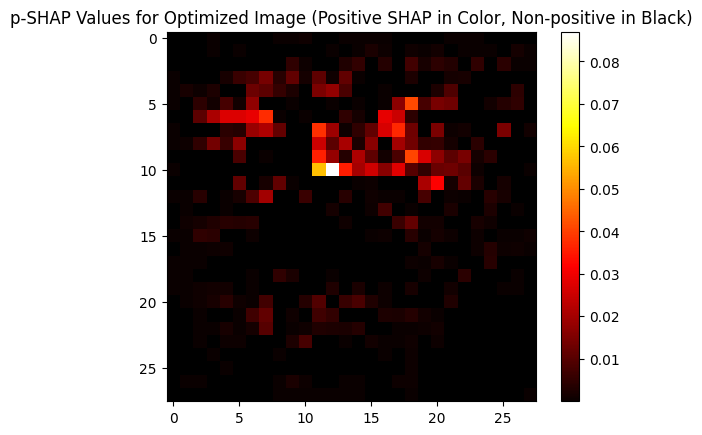

In [98]:
masked_p_shap_values = np.copy(p_shap_values)
masked_p_shap_values[masked_p_shap_values <= 0] = np.nan  

cmap = plt.get_cmap('hot')
cmap.set_bad(color='black')  

plt.imshow(masked_p_shap_values, cmap=cmap, interpolation='none')
plt.colorbar()
plt.title('p-SHAP Values for Optimized Image (Positive SHAP in Color, Non-positive in Black)')
plt.show()

Calculating SHAP for Counterfactuals:  10%|█         | 1/10 [00:05<00:51,  5.69s/it]

Iteration 1/10 completed in 5.69 seconds.


Calculating SHAP for Counterfactuals:  20%|██        | 2/10 [00:12<00:49,  6.13s/it]

Iteration 2/10 completed in 6.42 seconds.


Calculating SHAP for Counterfactuals:  30%|███       | 3/10 [00:17<00:39,  5.67s/it]

Iteration 3/10 completed in 5.12 seconds.


Calculating SHAP for Counterfactuals:  40%|████      | 4/10 [00:22<00:32,  5.43s/it]

Iteration 4/10 completed in 5.07 seconds.


Calculating SHAP for Counterfactuals:  50%|█████     | 5/10 [00:28<00:29,  5.81s/it]

Iteration 5/10 completed in 6.49 seconds.


Calculating SHAP for Counterfactuals:  60%|██████    | 6/10 [00:35<00:24,  6.07s/it]

Iteration 6/10 completed in 6.58 seconds.


Calculating SHAP for Counterfactuals:  70%|███████   | 7/10 [00:40<00:16,  5.65s/it]

Iteration 7/10 completed in 4.78 seconds.


Calculating SHAP for Counterfactuals:  80%|████████  | 8/10 [00:45<00:11,  5.69s/it]

Iteration 8/10 completed in 5.75 seconds.


Calculating SHAP for Counterfactuals:  90%|█████████ | 9/10 [00:52<00:05,  5.88s/it]

Iteration 9/10 completed in 6.32 seconds.


Calculating SHAP for Counterfactuals: 100%|██████████| 10/10 [00:57<00:00,  5.74s/it]

Iteration 10/10 completed in 5.16 seconds.
Maximum absolute SHAP value: 6.109663522611841e-05


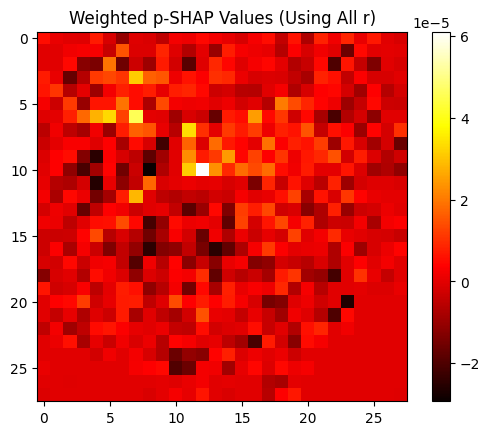

In [99]:
import shap
import numpy as np
import warnings
import matplotlib.pyplot as plt
import time
from tqdm import tqdm  # For progress bar

warnings.filterwarnings("ignore")

class WeightedExplainer:
    def __init__(self, model):
        self.model = model

    def explain_instance(self, x, X_baseline, joint_probabilities, sample_size=500, shap_sample_size="auto"):
        # Sample baseline randomly without using weights
        indice = np.random.choice(X_baseline.shape[0], replace=True, size=sample_size)
        indice = np.unique(indice)  # Ensure unique sampling
        sampled_X_baseline = X_baseline[indice]

        # Use KernelExplainer from SHAP to calculate shap values
        explainer_temp = shap.KernelExplainer(self.model.predict, sampled_X_baseline)

        # Calculate shap values for the input x
        shap_values = explainer_temp.shap_values(x, nsamples=shap_sample_size)

        # Transpose the SHAP values so that joint probabilities can be applied along the correct dimension
        shap_values = np.array(shap_values).T  # Shape: (10, 784) after transposing

        # Weight the SHAP values by the joint probabilities (apply probabilities across the 10 samples)
        weighted_shap_values = shap_values * joint_probabilities[:, None]  # Shape: (10, 784)

        return weighted_shap_values.T  # Return the result with shape (784, 10)

# Instantiate the explainer for the CNN model
explainer = WeightedExplainer(cnn)

# Assuming X_flat (original input flattened to 1D) is defined
X_flat = X.flatten()  # Flatten the original image to 1D

# List to store SHAP values for each pixel (we'll accumulate over all r)
shap_values_list = []

# Track time for total execution
start_time = time.time()

# Iterate over each counterfactual r (from most_diverse_images_) with tqdm progress bar
for counterfactual_index in tqdm(range(10), desc="Calculating SHAP for Counterfactuals"):  # 10 counterfactuals
    iteration_start_time = time.time()  # Start timing for this iteration

    r_flat = np.copy(most_diverse_images_[counterfactual_index].flatten())  # Flatten the current counterfactual

    X_baseline = np.tile(X_flat, (10, 1))  

    weighted_shap_values = explainer.explain_instance(
        r_flat, X_baseline, joint_probabilities=joint_probabilities, sample_size=500
    )

    abs_weighted_shap_values = np.abs(weighted_shap_values)

    shap_values_list.append(weighted_shap_values)

    iteration_time = time.time() - iteration_start_time
    print(f"Iteration {counterfactual_index + 1}/10 completed in {iteration_time:.2f} seconds.")

weighted_shap_values = np.mean(shap_values_list, axis=0) 

final_weighted_shap_values = np.mean(weighted_shap_values, axis=1)

print(f"Maximum absolute SHAP value: {np.max(final_weighted_shap_values)}")

plt.imshow(final_weighted_shap_values.reshape(28, 28), cmap='hot')
plt.colorbar()
plt.title('Weighted p-SHAP Values (Using All r)')
plt.show()


In [100]:
# import shap
# import numpy as np
# import warnings
# warnings.filterwarnings("ignore") 

# class WeightedExplainer:
#     def __init__(self, model):
#         self.model = model

#     def explain_instance(self, x, X_baseline, sample_size=500, shap_sample_size="auto"):
#         # Sample baseline randomly without using weights
#         indice = np.random.choice(X_baseline.shape[0], replace=True, size=sample_size)
#         indice = np.unique(indice)  # Ensure unique sampling
#         sampled_X_baseline = X_baseline[indice]

#         # Use KernelExplainer from SHAP to calculate shap values
#         explainer_temp = shap.KernelExplainer(self.model.predict, sampled_X_baseline)
#         shap_values = explainer_temp.shap_values(x, nsamples=shap_sample_size)

#         return shap_values

# # Instantiate the explainer for the CNN model
# explainer = WeightedExplainer(cnn)

# # Assuming X_flat (original input flattened to 1D) is defined
# X_flat = X.flatten()  # Flatten the original image to 1D

# # List to store SHAP values for each pixel (we'll accumulate over all r)
# shap_values_list = []

# # Iterate over each counterfactual r (from all_results_flat)
# for counterfactual_index in range(100):  # 100 counterfactuals
#     r_flat = np.copy(all_results_flat[counterfactual_index].flatten())  # Flatten the current counterfactual

#     # List to store the SHAP values for the current counterfactual
#     shap_values_for_r = []

#     # Create a baseline set using the original image (X_flat)
#     X_baseline = np.tile(X_flat, (100, 1))  # Use the 100 original images as baseline without weighting

#     # Iterate over each pixel in the flattened original image
#     for idx, pixel in enumerate(X_flat): 
#         # Modify the counterfactual image at pixel `idx` with the value from X
#         modified_image = np.copy(r_flat)
#         modified_image[idx] = pixel  
#         complete_image = modified_image.reshape(1, 784)  # Reshape to 28x28 for CNN input

#         # Calculate SHAP values using the explainer for the current counterfactual
#         shap_values = explainer.explain_instance(
#             complete_image, X_baseline, sample_size=500
#         )
        
#         # Append the SHAP values for this pixel for the current counterfactual
#         shap_values_for_r.append(shap_values)

#     # Store SHAP values for this counterfactual
#     shap_values_list.append(np.array(shap_values_for_r))

# # Now, we compute the unweighted average of the SHAP values across all r's
# unweighted_shap_values = np.mean(shap_values_list, axis=0)  # Take the average across all 100 r's

# # Output the unweighted SHAP values for all pixels
# print("Unweighted SHAP values for all pixels (average over all r's):", unweighted_shap_values, flush=True)

# # Visualize the unweighted SHAP values as a heatmap
# plt.imshow(unweighted_shap_values.reshape(28, 28), cmap='hot')
# plt.colorbar()
# plt.title('Unweighted p-SHAP Values (Using All r)')
# plt.show()


In [101]:
p_shap_values.max()


0.08700163172084958

In [102]:
p_shap_values.min()

-0.028723553878292396

In [103]:
# cnn = load_model('mnist_cnn.h5')
# all_results_maxp = best_image

# class WeightedExplainer:
#     def __init__(self, model):
#         self.model = model

#     def explain_instance(self, x, X_baseline, weights, sample_size=500, shap_sample_size="auto"):
#         EPSILON = 1e-20
#         weights = weights + EPSILON
#         weights = weights / weights.sum() 

#         indice = np.random.choice(X_baseline.shape[0], p=weights, replace=True, size=sample_size)
#         indice = np.unique(indice)
#         sampled_X_baseline = X_baseline[indice]

#         explainer_temp = shap.KernelExplainer(self.model.predict, sampled_X_baseline)
#         shap_values = explainer_temp.shap_values(x, nsamples=shap_sample_size)

#         return shap_values

# weighted_explainer = WeightedExplainer(cnn)

# r = np.copy(all_results_maxp) 

# X_flat = X.flatten()  
# r_flat = np.copy(all_results_flat[max_p_index].flatten()) 

# shap_values_list = []

# X_baseline = np.tile(X_flat, (joint_probabilities.shape[0], 1))

# for idx, pixel in enumerate(X_flat): 
#     modified_image = np.copy(r_flat)
#     modified_image[idx] = pixel  
#     complete_image = modified_image.reshape(1, 784) 

#     joint_probabilities_for_pixel_i = joint_probabilities[:, idx]
#     joint_probabilities_for_pixel_i = np.round(joint_probabilities_for_pixel_i, 2)
#     weights_sum = joint_probabilities_for_pixel_i.sum()
#     if weights_sum != 1:
#         residual = 1 - weights_sum
#         max_prob_index = np.argmax(joint_probabilities_for_pixel_i)
#         joint_probabilities_for_pixel_i[max_prob_index] += residual

#     shap_values = weighted_explainer.explain_instance(
#         complete_image, X_baseline, joint_probabilities_for_pixel_i, sample_size=500
#     )
    
#     shap_values_list.append(shap_values)
    
# import warnings
# warnings.filterwarnings("ignore") 

# print("SHAP values for pixels in r (counterfactual):", shap_values_list, flush=True)



## Replacing X with q_matrix based on the sorted shap_values

In [104]:
sorted_shap_values = np.sort(p_shap_values, axis=None)[::-1] 

sorted_indices = np.argsort(p_shap_values, axis=None)[::-1]  

coordinates = np.unravel_index(sorted_indices, (28, 28)) 

sorted_shap_with_coords = list(zip(sorted_shap_values, zip(coordinates[0], coordinates[1])))

positive_shap_values_with_coords = [(value, coord) for value, coord in sorted_shap_with_coords if value>0]
print(positive_shap_values_with_coords)

for value, coord in positive_shap_values_with_coords:
    print(f"SHAP value: {value:.6f}, Coordinate: {coord}")


[(0.08700163172084958, (10, 12)), (0.05668054141916414, (10, 11)), (0.041386494729903536, (5, 18)), (0.04075234352284999, (9, 18)), (0.03790243044501898, (7, 11)), (0.03740715245050227, (6, 7)), (0.03699188338473423, (7, 17)), (0.03596505271112359, (9, 11)), (0.0353463296701894, (10, 13)), (0.031662878884267644, (11, 20)), (0.029224877380625867, (6, 6)), (0.028580726065654066, (6, 16)), (0.02798003687742466, (10, 17)), (0.027417022763872284, (6, 5)), (0.027371494363951355, (6, 4)), (0.02708916529166184, (9, 19)), (0.02655762805414636, (7, 16)), (0.02563180805326977, (10, 15)), (0.025463011012995328, (8, 11)), (0.02504724147911367, (6, 17)), (0.021621667721888376, (7, 7)), (0.021179948796050906, (9, 14)), (0.020887057465519242, (6, 3)), (0.02080082366322137, (11, 19)), (0.020544632770295737, (8, 13)), (0.020060517154340828, (10, 14)), (0.019949727394185067, (12, 7)), (0.019887760044263725, (8, 17)), (0.019332860796404634, (7, 12)), (0.018470345415145206, (7, 6)), (0.018067662260863905, 

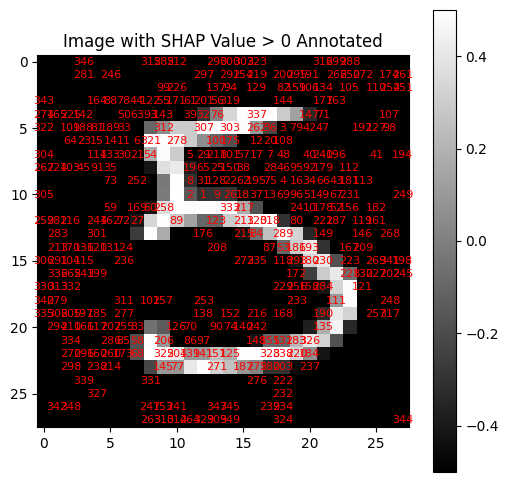

In [105]:
plt.figure(figsize=(6, 6))
plt.imshow(X_reshaped, cmap='gray', interpolation='none')
plt.title('Image with SHAP Value > 0 Annotated')

for rank, (value, (i, j)) in enumerate(positive_shap_values_with_coords):
    plt.text(j, i, str(rank + 1), color='red', fontsize=8, ha='center', va='center') 

plt.colorbar()
plt.show()


Target label 3 predicted after 76 replacements.


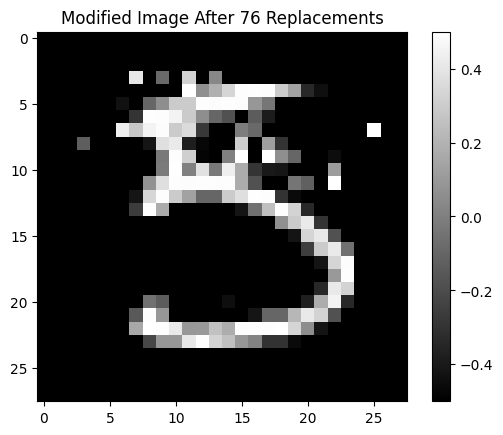

Predictions after each replacement:
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3]


In [106]:
import numpy as np
import matplotlib.pyplot as plt

def replace_pixels_using_shap(X, best_image, positive_shap_values_with_coords, cnn, target_label=3):
    """
    Iteratively replace pixels in X with those from best_image based on positive SHAP values (in descending order),
    and check the model's prediction after each replacement. Stores and prints prediction results.
    
    Arguments:
    - X: Original image (1D array, 784 elements)
    - best_image: Counterfactual image (1D array, 784 elements)
    - positive_shap_values_with_coords: List of positive SHAP values with their coordinates (sorted in descending order)
    - cnn: The model used for prediction
    - target_label: The target label to check (default = 3)
    
    Returns:
    - X_modified: Modified image after replacement
    - num_replacements: The number of pixels replaced to achieve the target prediction
    - predictions_array: List of prediction results after each replacement
    """

    X_modified = X.reshape(28, 28).copy()
    best_image_reshaped = best_image.reshape(28, 28)

    predictions_array = []  

    for rank, (value, (i, j)) in enumerate(positive_shap_values_with_coords):
        X_modified[i, j] = best_image_reshaped[i, j]
   
        prediction = cnn.predict(X_modified.reshape(1, 784))
        predicted_class = np.argmax(prediction)
        predictions_array.append(predicted_class) 

        if predicted_class == target_label:
            print(f"Target label {target_label} predicted after {rank + 1} replacements.")
            return X_modified, rank + 1, predictions_array  

    return X_modified, len(positive_shap_values_with_coords), predictions_array

X = X_tensor.cpu().numpy() 

X_modified, num_replacements, predictions_array = replace_pixels_using_shap(X, best_image, positive_shap_values_with_coords, cnn)

plt.imshow(X_modified, cmap='gray')
plt.colorbar()
plt.title(f'Modified Image After {num_replacements} Replacements')
plt.show()

print("Predictions after each replacement:")
print(predictions_array)


51


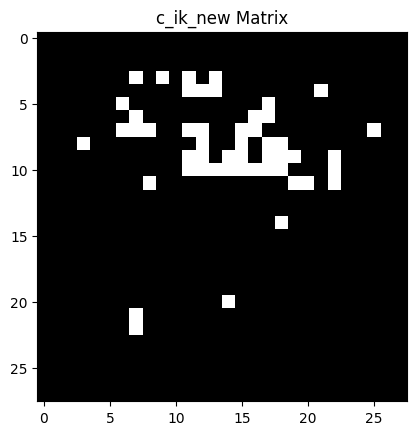

3


In [107]:
c_ik_cp = np.where(X.reshape(28,28) != X_modified.reshape(28,28), 1, 0)
changed_pixel_opti = np.sum(c_ik_cp)
print(changed_pixel_opti)
plt.imshow(c_ik_cp.reshape(28,28),cmap='gray')
plt.title('c_ik_new Matrix')
plt.show()
print(cnn.predict(PN_optimized1.reshape(1,784)).argmax())

In [108]:
# cnn = load_model('mnist_cnn.h5')

# def predict_after_replacement(X_flat, r_flat, sorted_indices, num_replacements):
#     modified_X = np.copy(X_flat)
    
#     for i in range(num_replacements):
#         idx = sorted_indices[i]
#         modified_X[idx] = r_flat[idx]  
#     modified_image = modified_X.reshape(1, 784)  

#     prediction = cnn.predict(modified_image)
#     predicted_class = np.argmax(prediction) 
    
#     return predicted_class

# num_pixels_to_replace = 33
# prediction_results = []

# for n in range(1, num_pixels_to_replace + 1):
#     predicted_class = predict_after_replacement(X_flat, r_flat, sorted_indices, n)
#     prediction_results.append(predicted_class)

# print("Prediction results after each pixel replacement:", prediction_results)

## C = 18

In [109]:
C = predictions_array.count(5)
C

75